### Creating Facenet model

The CNN architecture used here is a variant of the inception architecture.

In [2]:
from model import create_model

nn4_small2 = create_model()


c:\python36(64bit)\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Model training aims to learn an embedding $f(x)$ of image $x$ such that the squared L2 distance between all faces of the same identity is small and the distance between a pair of faces from different identities is large. This can be achieved with a *triplet loss* $L$ that is minimized when the distance between an anchor image $x^a_i$ and a positive image $x^p_i$ (same identity) in embedding space is smaller than the distance between that anchor image and a negative image $x^n_i$ (different identity) by at least a margin $\alpha$.

$$L = \sum^{m}_{i=1} \large[ \small {\mid \mid f(x_{i}^{a}) - f(x_{i}^{p})) \mid \mid_2^2} - {\mid \mid f(x_{i}^{a}) - f(x_{i}^{n})) \mid \mid_2^2} + \alpha \large ] \small_+$$



In [3]:
nn4_small2_pretrained = create_model()
nn4_small2_pretrained.load_weights('weights/nn4.small2.v1.h5')

### Custom dataset

In [4]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
s='jpg'
a="jpeg"    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        #print(i)
        for f in os.listdir(os.path.join(path, i)):
             if f.endswith(s) or f.endswith(a):
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('Project')
print(metadata.shape[0])

101


### Face alignment

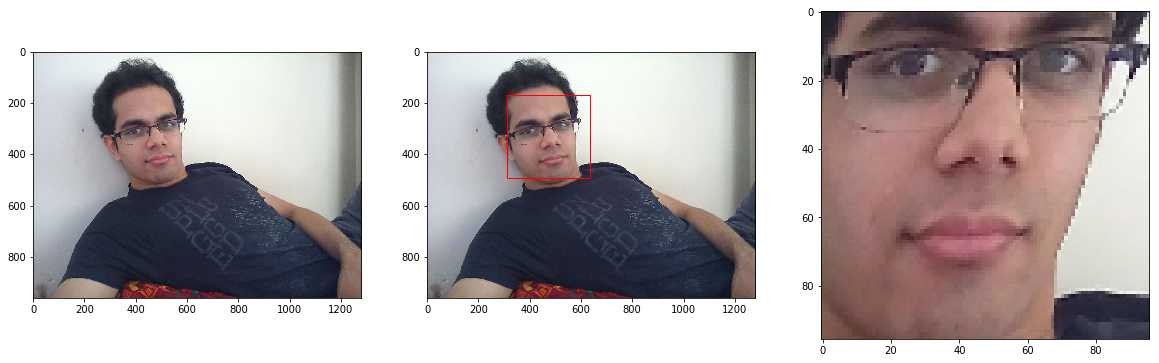

In [14]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline

def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    #destRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img[...,::-1]
    #return destRGB

# Initialize the OpenFace face alignment utility
alignment = AlignDlib('models/landmarks.dat')

# Load an image 
jc_orig = load_image(metadata[89].image_path())

# Detect face and return bounding box
bb = alignment.getLargestFaceBoundingBox(jc_orig)

# Transform image using specified face landmark indices and crop image to 96x96
jc_aligned = alignment.align(96, jc_orig, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

# Show original image
f = plt.figure(figsize=(20,20))
f.add_subplot(131)

#plt.subplots(figsize=(4, 4))
plt.imshow(jc_orig)
#f.savefig("example.jpg")
# Show original image with bounding box
f.add_subplot(132)
#subplots(figsize=(4, 4))
plt.imshow(jc_orig)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))
#f.savefig("detect_face.jpg")
# Show aligned image
f.add_subplot(133)
#plt.subplots(figsize=(4, 4))
plt.imshow(jc_aligned);
#f.savefig("align_face.jpg")

In [6]:
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

### Embedding vectors

Embedding vectors can now be calculated by feeding the aligned and scaled images into the pre-trained network.

In [7]:
embedded = np.zeros((metadata.shape[0], 128))

#print(metadata)
k=0
for i, m in enumerate(metadata):
    
        #print(i,m.image_path())
        img = load_image(m.image_path())
        
        img = align_image(img)
        # scale RGB values to interval [0,1]
        img = (img / 255.).astype(np.float32)
        # obtain embedding vector for image
        embedded[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]
      

Let's verify on a single triplet example that the squared L2 distance between its anchor-positive pair is smaller than the distance between its anchor-negative pair.

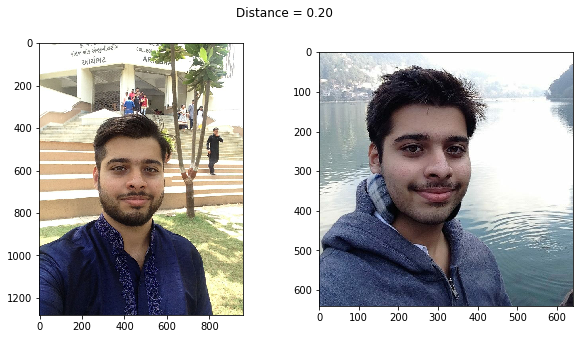

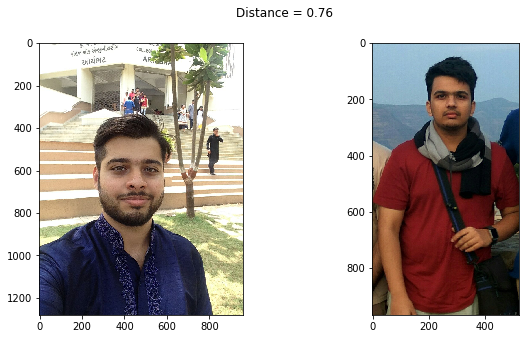

In [8]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    f=plt.figure(figsize=(10,5))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path())); 
 
show_pair(0, 8)
show_pair(0, 22)


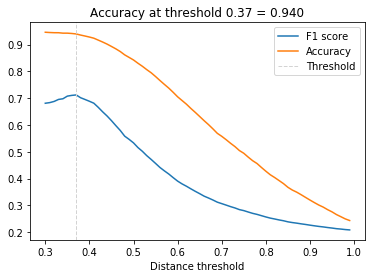

In [10]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata)

for i in range(num - 1):
    for j in range(1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();

As expected, the distance between the two images of Jacques Chirac is smaller than the distance between an image of Jacques Chirac and an image of Gerhard Schröder (0.30 < 1.12). But we still do not know what distance threshold $\tau$ is the best boundary for making a decision between *same identity* and *different identity*.

### Distance threshold

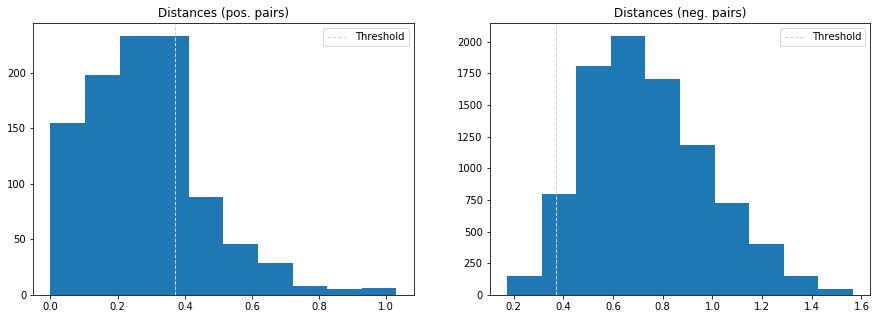

In [11]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]

fig=plt.figure(figsize=(15,5))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (pos. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (neg. pairs)')
plt.legend();
fig.savefig("dist_histo.jpg")

### Classifier 

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

train_idx = np.arange(metadata.shape[0]) % 2 != 0
test_idx = np.arange(metadata.shape[0]) % 2 == 0


# 50 train examples of 10 identities (5 examples each)
X_train = embedded[train_idx]
# 50 test examples of 10 identities (5 examples each)
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = SVC(kernel='linear', probability=True)

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

acc_knn = accuracy_score(y_test, knn.predict(X_test))
acc_svc = accuracy_score(y_test, svc.predict(X_test))

print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

KNN accuracy = 0.9411764705882353, SVM accuracy = 0.9019607843137255


### The KNN classifier achieves an accuracy of 92% on the test set, the SVM classifier 94%. 

### training with all  traininig data


In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

train_idx = np.arange(metadata.shape[0]) 

#test_idx = np.arange(metadata.shape[0]) % 2 == 0


# 50 train examples of 10 identities (5 examples each)
X_train = embedded[train_idx]
# 50 test examples of 10 identities (5 examples each)
#X_test = embedded[test_idx]

y_train = y[train_idx]
#y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = SVC(kernel='linear', probability=True)

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

#acc_knn = accuracy_score(y_test, knn.predict(X_test))
#acc_svc = accuracy_score(y_test, svc.predict(X_test))

#print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Dataset visualization

To embed the dataset into 2D space for displaying identity clusters, [t-distributed Stochastic Neighbor Embedding](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) (t-SNE) is applied to the 128-dimensional embedding vectors. Except from a few outliers, identity clusters are well separated.

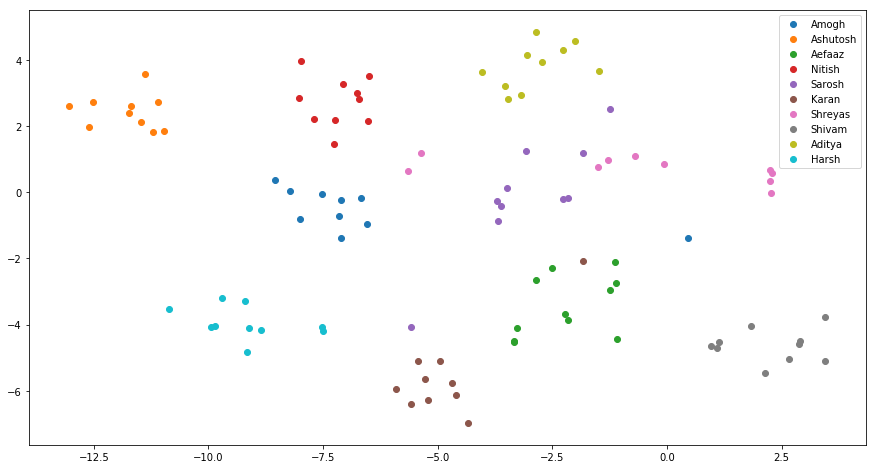

In [23]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embedded)
fig=plt.figure(figsize=(15,8))
for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));
fig.savefig("cluster.jpg")

# Face recognition based on Hog face detector

--- 3.4719729114042934 seconds ---


c:\python36(64bit)\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\python36(64bit)\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\python36(64bit)\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\python36(64bit)\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will resul

--- 4.127972535612386 seconds ---


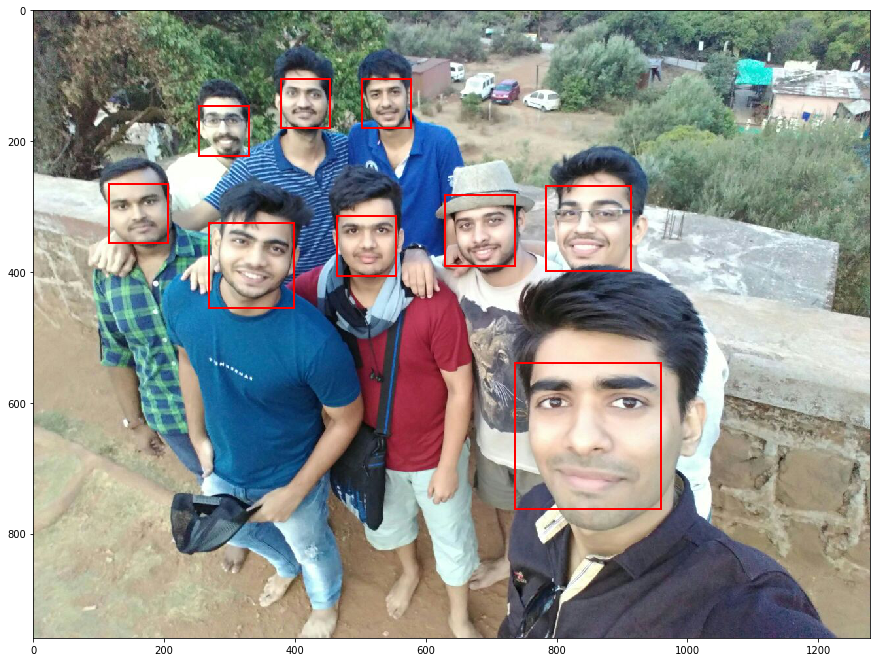

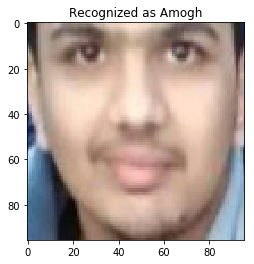

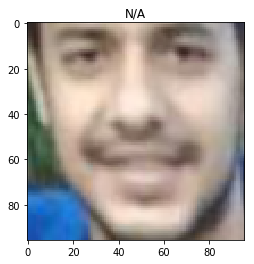

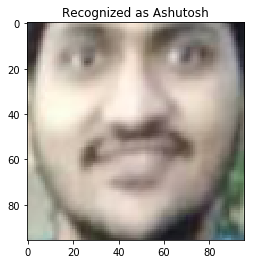

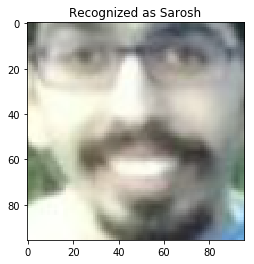

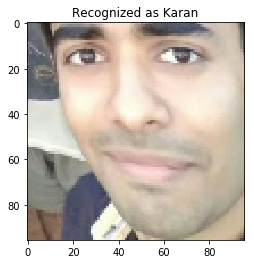

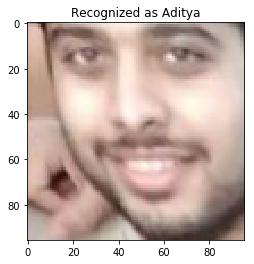

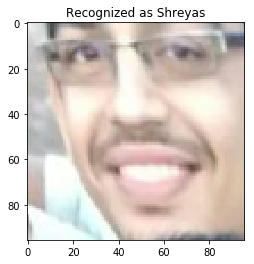

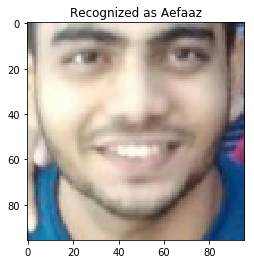

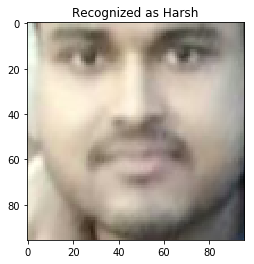

In [17]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
from align import AlignDlib
import numpy as np
%matplotlib inline
# Initialize the OpenFace face alignment utility

start_time = time.clock()
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    #destRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img[...,::-1]
    #return destRGB

alignment = AlignDlib('models/landmarks.dat')

# Load an image of Jacques Chirac
im_orig = load_image('t2.jpg')

# Detect face and return bounding box
bb = alignment.getAllFaceBoundingBoxes(im_orig)
#print(bb)
# Transform image using specified face landmark indices and crop image to 96x96
im_aligned=[]
for i in bb:
      j = alignment.align(96, im_orig, i, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
      im_aligned.append(j)   

# Show original image
#plt.subplot(221)
#plt.imshow(im_orig)

fig=plt.figure(figsize=(15,15))
plt.imshow(im_orig)
# Show original image with bounding box
#plt.subplot(222)
#print(im_aligned)
#plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))
for i in bb:
    
    plt.gca().add_patch(patches.Rectangle((i.left(), i.top()), i.width(), i.height(), fill=False, color='red',linewidth=2))

# Show aligned image
#plt.subplot(133)
#fig.savefig('time_hog_detection.jpg')
#print("--- %s seconds ---" % (time.clock() - start_time))
for n in im_aligned:
    n = (n / 255.).astype(np.float32)
    embedded_t = nn4_small2_pretrained.predict(np.expand_dims(n, axis=0))[0]
    #print(embedded)
    embedded_t=embedded_t.reshape(1,-1)
    #print( embedded_t)

    
        

    example_predic = knn.predict(embedded_t)
    example_prob = svc.predict_proba(embedded_t)
    #print(example_prob)
    if np.any(example_prob>0.25):
        example_i = encoder.inverse_transform(example_predic)[0]
        plt.subplots(figsize=(4, 4))
        plt.imshow(n)
    
        plt.title(f'Recognized as {example_i}')
           
    else:
            plt.subplots(figsize=(4, 4))
            plt.imshow(n)

            plt.title('N/A')
print("--- %s seconds ---" % (time.clock() - start_time))
            